## Classification Model for Utah

In [20]:
# packages used
import pandas as pd
import numpy as np
from sklearn import tree
#from sklearn.ensemble import BaggingClassifier
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

In [2]:
%run ./graph_counts.py

In [3]:
# Load the data
data_dir = 'Data/'
Stores = pd.read_csv(data_dir + 'AllStoresUtah.csv', dtype = str)
StoreType = pd.read_csv(data_dir + 'NonLowPointStoresUtah.csv', dtype = str)
Stores.head()

,RTL_STORE_CD,RTL_FIPS_COUNTY_DSC,RTL_PREMISE_TYPE_CD,RTL_CHANNEL_DSC,RTL_SUBCHANNEL_DSC,RTL_BEER_FLAG,RTL_LIQUOR_FLG
0,101856127,GRAND,OFF,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,Y,N
1,101948415,GARFIELD,OFF,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,Y,N
2,105604679,CACHE,ON,DINING,CASUAL DINING,Y,Y
3,100437548,SALT LAKE,OFF,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,Y,N
4,101943195,SALT LAKE,OFF,EXTENDED MASTER OFF-PREMISE,OTHER OFF-PREMISE,N,N


In [4]:
StoreType.head()

,RTL_STORE_CD,BEERTYPE
0,101415037,NonLowPoint
1,201880474,NonLowPoint
2,101415040,NonLowPoint
3,101415045,NonLowPoint
4,103755213,NonLowPoint


In [5]:
FullData = pd.merge(Stores, StoreType, on="RTL_STORE_CD", how="left")

In [6]:
FullData.loc[FullData['BEERTYPE'].isnull(),"BEERTYPE"] = "LowPoint"

In [7]:
FullData = pd.concat([FullData, pd.get_dummies(FullData['RTL_FIPS_COUNTY_DSC'],prefix='COUNTY')], axis=1)
FullData = pd.concat([FullData, pd.get_dummies(FullData['RTL_PREMISE_TYPE_CD'],prefix='PREMISE')], axis=1)
FullData = pd.concat([FullData, pd.get_dummies(FullData['RTL_CHANNEL_DSC'],prefix='CHANNEL')], axis=1)
FullData = pd.concat([FullData, pd.get_dummies(FullData['RTL_SUBCHANNEL_DSC'],prefix='SUBCHANNEL')], axis=1)
FullData = pd.concat([FullData, pd.get_dummies(FullData['RTL_BEER_FLAG'],prefix='BEER_LICENSE')], axis=1)
FullData = pd.concat([FullData, pd.get_dummies(FullData['RTL_LIQUOR_FLG'],prefix='LIQUOR_LICENSE')], axis=1)
FullData.head()

,RTL_STORE_CD,RTL_FIPS_COUNTY_DSC,RTL_PREMISE_TYPE_CD,RTL_CHANNEL_DSC,RTL_SUBCHANNEL_DSC,RTL_BEER_FLAG,RTL_LIQUOR_FLG,BEERTYPE,COUNTY_BEAVER,COUNTY_BOX ELDER,...,SUBCHANNEL_THEATER,SUBCHANNEL_TRADING POST,SUBCHANNEL_UNKNOWN,SUBCHANNEL_WINE SPECIALTY STORE,BEER_LICENSE_N,BEER_LICENSE_U,BEER_LICENSE_Y,LIQUOR_LICENSE_N,LIQUOR_LICENSE_U,LIQUOR_LICENSE_Y
0,101856127,GRAND,OFF,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,Y,N,LowPoint,0,0,...,0,0,0,0,0,0,1,1,0,0
1,101948415,GARFIELD,OFF,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,Y,N,LowPoint,0,0,...,0,0,0,0,0,0,1,1,0,0
2,105604679,CACHE,ON,DINING,CASUAL DINING,Y,Y,LowPoint,0,0,...,0,0,0,0,0,0,1,0,0,1
3,100437548,SALT LAKE,OFF,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,Y,N,LowPoint,0,0,...,0,0,0,0,0,0,1,1,0,0
4,101943195,SALT LAKE,OFF,EXTENDED MASTER OFF-PREMISE,OTHER OFF-PREMISE,N,N,LowPoint,0,0,...,0,0,0,0,1,0,0,1,0,0


# Business Rules 

In [10]:
RulesData = pd.merge(Stores, StoreType, on="RTL_STORE_CD", how="left")
RulesData.loc[RulesData['BEERTYPE'].isnull(),"BEERTYPE"] = "LowPoint"
RulesData.to_csv(data_dir + 'RulesDataUtah.csv')
RulesData['LowPoint_Y'] = ""
RulesData.head()

,RTL_STORE_CD,RTL_FIPS_COUNTY_DSC,RTL_PREMISE_TYPE_CD,RTL_CHANNEL_DSC,RTL_SUBCHANNEL_DSC,RTL_BEER_FLAG,RTL_LIQUOR_FLG,BEERTYPE,LowPoint_Y
0,101856127,GRAND,OFF,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,Y,N,LowPoint,
1,101948415,GARFIELD,OFF,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,Y,N,LowPoint,
2,105604679,CACHE,ON,DINING,CASUAL DINING,Y,Y,LowPoint,
3,100437548,SALT LAKE,OFF,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,Y,N,LowPoint,
4,101943195,SALT LAKE,OFF,EXTENDED MASTER OFF-PREMISE,OTHER OFF-PREMISE,N,N,LowPoint,


In [21]:
def Rules_Utah(dataframe):

    for row in range(len(dataframe)):
        if dataframe.loc[row,'RTL_CHANNEL_DSC'] == 'LIQUOR' or 'MILITARY' in dataframe.loc[row,'RTL_CHANNEL_DSC']:
            
            dataframe.loc[row,'LowPoint_Y'] = False
        else:
            
            dataframe.loc[row,'LowPoint_Y'] = True
    
    return dataframe

#save the Utah business rule into pickle
pickle.dump(Rules_Utah, open('Utah_business_rule.p', 'wb'))

In [23]:
Utah_rule_func = pickle.load(open('Utah_business_rule.p', 'rb'))
        
result_df = Utah_rule_func(RulesData)
result_df.head()
        

,RTL_STORE_CD,RTL_FIPS_COUNTY_DSC,RTL_PREMISE_TYPE_CD,RTL_CHANNEL_DSC,RTL_SUBCHANNEL_DSC,RTL_BEER_FLAG,RTL_LIQUOR_FLG,BEERTYPE,LowPoint_Y
0,101856127,GRAND,OFF,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,Y,N,LowPoint,True
1,101948415,GARFIELD,OFF,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,Y,N,LowPoint,True
2,105604679,CACHE,ON,DINING,CASUAL DINING,Y,Y,LowPoint,True
3,100437548,SALT LAKE,OFF,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,Y,N,LowPoint,True
4,101943195,SALT LAKE,OFF,EXTENDED MASTER OFF-PREMISE,OTHER OFF-PREMISE,N,N,LowPoint,True


In [18]:
tempDF = Rules_Utah(RulesData)
tempDF.head()

,RTL_STORE_CD,RTL_FIPS_COUNTY_DSC,RTL_PREMISE_TYPE_CD,RTL_CHANNEL_DSC,RTL_SUBCHANNEL_DSC,RTL_BEER_FLAG,RTL_LIQUOR_FLG,BEERTYPE,LowPoint_Y
0,101856127,GRAND,OFF,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,Y,N,LowPoint,True
1,101948415,GARFIELD,OFF,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,Y,N,LowPoint,True
2,105604679,CACHE,ON,DINING,CASUAL DINING,Y,Y,LowPoint,True
3,100437548,SALT LAKE,OFF,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,Y,N,LowPoint,True
4,101943195,SALT LAKE,OFF,EXTENDED MASTER OFF-PREMISE,OTHER OFF-PREMISE,N,N,LowPoint,True


# Business Rules result

In [16]:
# Confusion Matrix
cm = confusion_matrix(RulesData['BEERTYPE'], tempDF['LowPoint_Y'])
cm

array([[2356,    4],
       [   0,   42]])

In [20]:
#Accuracy
Accuracy = (cm[0,0] + cm[1,1])/ np.sum(cm)
Accuracy

0.99833472106577847

In [21]:
#check how many stores are predicted wrong; which are they; what characters do they have
error_index_list = []
for index in range(len(RulesData)):
    if RulesData.loc[index , 'BEERTYPE'] != RulesData.loc[index , 'PREDICTION']:
        error_index_list.append(index)
print('there are', len(error_index_list), 'false_LowPoint errors in the prediction')

#check the error predictions
error_df = RulesData.loc[error_index_list, ]
error_df.head()

there are 4 false_LowPoint errors in the prediction


,RTL_STORE_CD,RTL_FIPS_COUNTY_DSC,RTL_PREMISE_TYPE_CD,RTL_CHANNEL_DSC,RTL_SUBCHANNEL_DSC,RTL_BEER_FLAG,RTL_LIQUOR_FLG,BEERTYPE,PREDICTION
151,101415007,DAVIS,OFF,MILITARY OFF-PREMISE,MILITARY LIQUOR STORE,Y,Y,LowPoint,NonLowPoint
293,101840007,DAVIS,ON,MILITARY ON-PREMISE,MILITARY RECREATION,Y,Y,LowPoint,NonLowPoint
322,101980806,DAVIS,ON,MILITARY ON-PREMISE,MILITARY DINING,Y,Y,LowPoint,NonLowPoint
1386,101840009,DAVIS,ON,MILITARY ON-PREMISE,MILITARY RECREATION,Y,Y,LowPoint,NonLowPoint


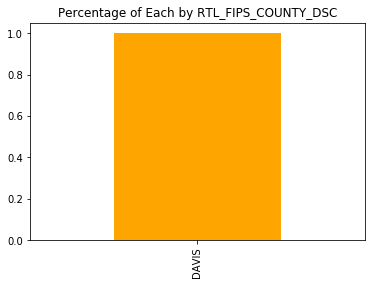

In [22]:
false_LowPoint = error_df.loc[error_df['BEERTYPE'] == 'LowPoint']
#create false_NonLowPoint by County
graph_counts(false_LowPoint, 'RTL_FIPS_COUNTY_DSC', False, 'bar', True, 15)

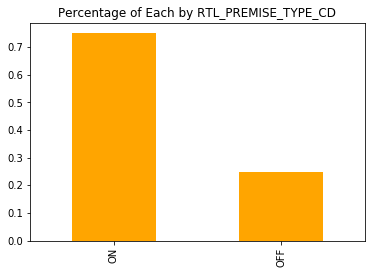

In [23]:
#create false_LowPoint by premise type
graph_counts(false_LowPoint, 'RTL_PREMISE_TYPE_CD', False, 'bar', True, 15)

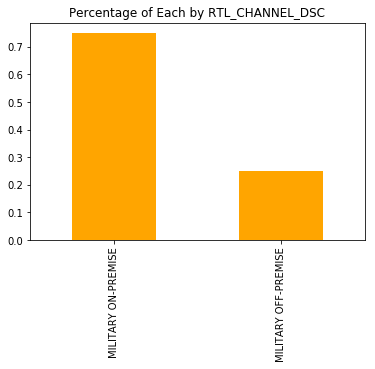

In [24]:
#create false_LowPoint by Channel
graph_counts(false_LowPoint, 'RTL_CHANNEL_DSC', False, 'bar', True, 15)

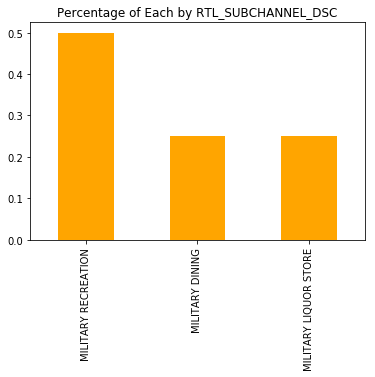

In [25]:
#create false_LowPoint by sub channel
graph_counts(false_LowPoint, 'RTL_SUBCHANNEL_DSC', False, 'bar', True, 15)

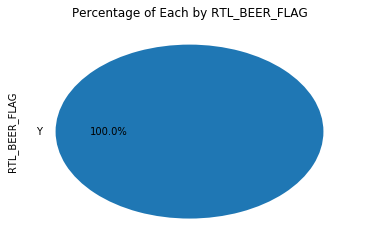

In [26]:
#create false_LowPoint by Beer License
graph_counts(false_LowPoint, 'RTL_BEER_FLAG', False, 'pie', True, 15)

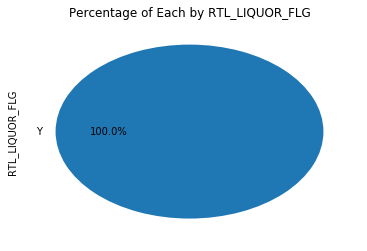

In [27]:
#create false_LowPoint by Liquor License
graph_counts(false_LowPoint, 'RTL_LIQUOR_FLG', False, 'pie', True, 15)

### Decision Tree Approach

In [28]:
# prepare data to fit model
X_labels = [c for c in FullData.columns if c not in ['RTL_STORE_CD','BEERTYPE','RTL_FIPS_COUNTY_DSC','RTL_PREMISE_TYPE_CD','RTL_CHANNEL_DSC','RTL_SUBCHANNEL_DSC','RTL_BEER_FLAG',"RTL_LIQUOR_FLG"]]
X = FullData.loc[:,X_labels]
Y = FullData['BEERTYPE']

In [29]:
parameters = {'max_depth':range(1,21), 'min_samples_leaf':range(3,21,3), 'min_samples_split':range(3,21,3), 'random_state': [0]}
clf = tree.DecisionTreeClassifier()
clf = GridSearchCV(clf, parameters, n_jobs = -2)
clf.fit(X, Y)
best_params = clf.best_params_
best_params

{'max_depth': 2,
 'min_samples_leaf': 3,
 'min_samples_split': 3,
 'random_state': 0}

# Decision Tree Result

In [30]:
#the result: with the best tree depth and accuracy
best_depth = best_params['max_depth']
best_leaf = best_params['min_samples_leaf']
best_split = best_params['min_samples_split']
accuracy = clf.best_score_ 

print('the best depth is:', best_depth, 'with minimium leaf =',best_leaf , 'minimium split =',best_split, 'with accuracy:',round(accuracy*100, 3), '%')

the best depth is: 2 with minimium leaf = 3 minimium split = 3 with accuracy: 99.917 %


In [31]:
#check the errors:

#create a new data frame to store the prediction result. 
result_df = FullData.loc[:, 'RTL_STORE_CD': 'BEERTYPE']
result_df['PRED_RESULT'] = clf.predict(X)
result_df.head()

,RTL_STORE_CD,RTL_FIPS_COUNTY_DSC,RTL_PREMISE_TYPE_CD,RTL_CHANNEL_DSC,RTL_SUBCHANNEL_DSC,RTL_BEER_FLAG,RTL_LIQUOR_FLG,BEERTYPE,PRED_RESULT
0,101856127,GRAND,OFF,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,Y,N,LowPoint,LowPoint
1,101948415,GARFIELD,OFF,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,Y,N,LowPoint,LowPoint
2,105604679,CACHE,ON,DINING,CASUAL DINING,Y,Y,LowPoint,LowPoint
3,100437548,SALT LAKE,OFF,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,Y,N,LowPoint,LowPoint
4,101943195,SALT LAKE,OFF,EXTENDED MASTER OFF-PREMISE,OTHER OFF-PREMISE,N,N,LowPoint,LowPoint


In [32]:
#check how many stores are predicted wrong; which are they; what characters do they have
error_index_list = []
for index in range(len(result_df)):
    if result_df.ix[index , 'BEERTYPE'] != result_df.ix[index , 'PRED_RESULT']:
        error_index_list.append(index)
print('there are', len(error_index_list), 'errors in the prediction')

there are 2 errors in the prediction


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  after removing the cwd from sys.path.


In [33]:
#check the error predictions
error_df = result_df.ix[error_index_list, ]
false_NonLowPoint = error_df.loc[error_df['BEERTYPE'] == 'LowPoint']
false_LowPoint = error_df.loc[error_df['BEERTYPE'] == 'NonLowPoint']
print('there are', len(false_NonLowPoint), 'false_NonLowPoint errors.')
print('there are', len(false_LowPoint), 'false_LowPoint errors.')
false_NonLowPoint.head()

there are 1 false_NonLowPoint errors.
there are 1 false_LowPoint errors.


,RTL_STORE_CD,RTL_FIPS_COUNTY_DSC,RTL_PREMISE_TYPE_CD,RTL_CHANNEL_DSC,RTL_SUBCHANNEL_DSC,RTL_BEER_FLAG,RTL_LIQUOR_FLG,BEERTYPE,PRED_RESULT
151,101415007,DAVIS,OFF,MILITARY OFF-PREMISE,MILITARY LIQUOR STORE,Y,Y,LowPoint,NonLowPoint


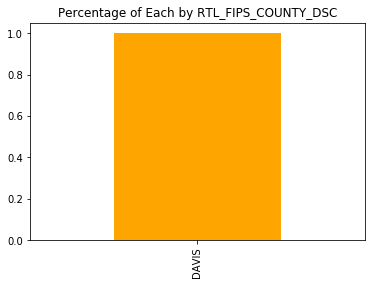

In [34]:
#create false_NonLowPoint by County
graph_counts(false_NonLowPoint, 'RTL_FIPS_COUNTY_DSC', False, 'bar', True, 15)

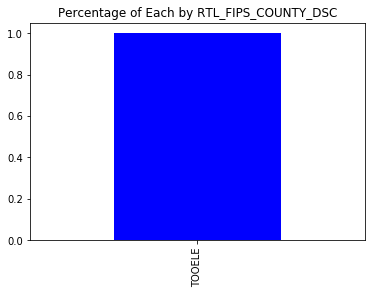

In [35]:
#create false_LowPoint by County
graph_counts(false_LowPoint, 'RTL_FIPS_COUNTY_DSC', False, 'bar', True, 15)

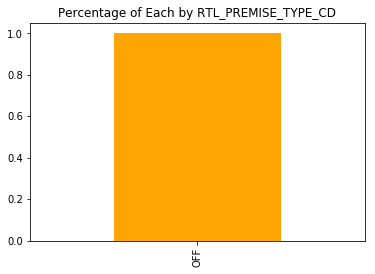

In [36]:
#create false_NonLowPoint by premise type
graph_counts(false_NonLowPoint, 'RTL_PREMISE_TYPE_CD', False, 'bar', True, 15)

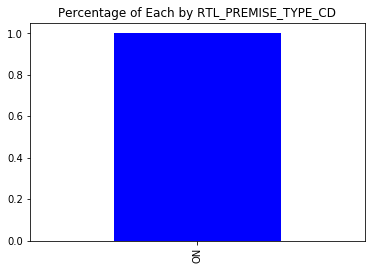

In [37]:
#create false_LowPoint by premise type
graph_counts(false_LowPoint, 'RTL_PREMISE_TYPE_CD', False, 'bar', True, 15)

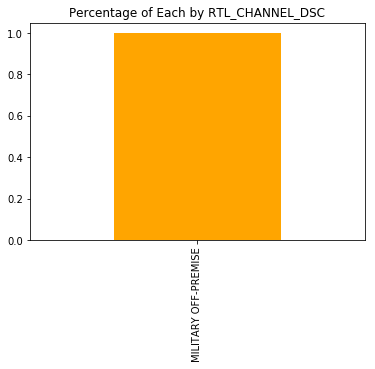

In [38]:
#create false_NonLowPoint by Channel
graph_counts(false_NonLowPoint, 'RTL_CHANNEL_DSC', False, 'bar', True, 15)

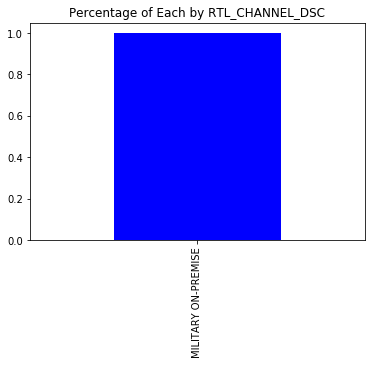

In [39]:
#create false_LowPoint by Channel
graph_counts(false_LowPoint, 'RTL_CHANNEL_DSC', False, 'bar', True, 15)

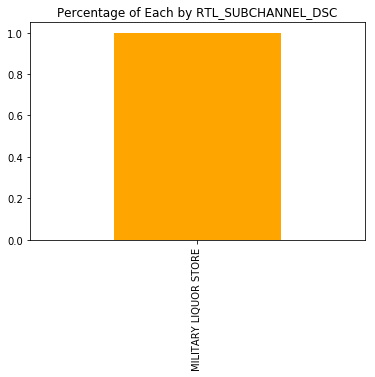

In [40]:
#create false_NonLowPoint by sub channel
graph_counts(false_NonLowPoint, 'RTL_SUBCHANNEL_DSC', False, 'bar', True, 15)

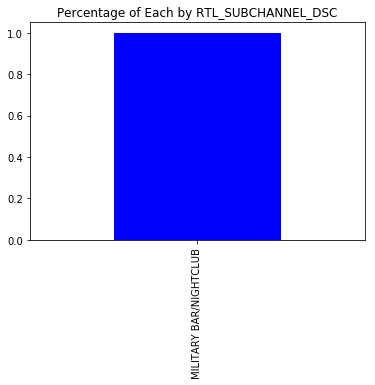

In [41]:
#create false_LowPoint by sub channel
graph_counts(false_LowPoint, 'RTL_SUBCHANNEL_DSC', False, 'bar', True, 15)

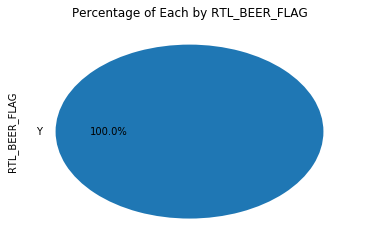

In [42]:
#create false_NonLowPoint by Beer License
graph_counts(false_NonLowPoint, 'RTL_BEER_FLAG', False, 'pie', True, 15)

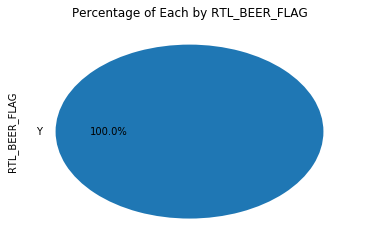

In [43]:
#create false_LowPoint by Beer License
graph_counts(false_LowPoint, 'RTL_BEER_FLAG', False, 'pie', True, 15)

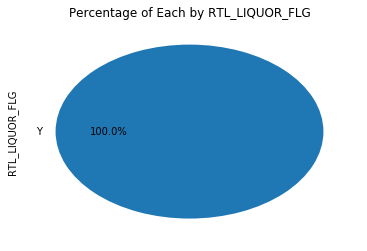

In [44]:
#create false_NonLowPoint by Liquor License
graph_counts(false_NonLowPoint, 'RTL_LIQUOR_FLG', False, 'pie', True, 15)

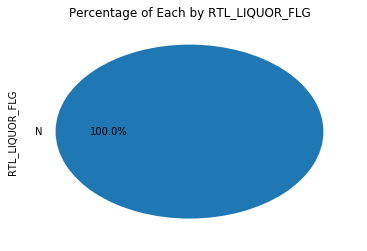

In [45]:
#create false_LowPoint by Liquor License
graph_counts(false_LowPoint, 'RTL_LIQUOR_FLG', False, 'pie', True, 15)

In [46]:
#feature importance
clf = tree.DecisionTreeClassifier(max_depth=best_depth, min_samples_leaf= best_leaf, min_samples_split = best_split, random_state=0)
clf = clf.fit(X,Y)

#all the features with their importance scores.
feature_score = pd.Series(data=clf.feature_importances_, index=X.columns).sort_values(ascending = False)

#only show the features that have scores greater than 0
feature_score[feature_score > 0]


CHANNEL_LIQUOR                  0.89471
CHANNEL_MILITARY OFF-PREMISE    0.10529
dtype: float64

In [47]:
# Confusion Matrix
cm = confusion_matrix(result_df['BEERTYPE'], result_df['PRED_RESULT'])
cm

array([[2359,    1],
       [   1,   41]])

In [48]:
# True Positive Rate
TPR = cm[1,1]/(cm[1,1]+cm[1,0])
TPR

0.97619047619047616

In [49]:
# False Negative Rate
FNR = cm[1,0]/(cm[1,0]+cm[1,1])
FNR

0.023809523809523808

In [50]:
# True Negative Rate
TNR = cm[0,0]/(cm[0,0]+cm[0,1])
TNR

0.99957627118644066

In [51]:
# False Positive Rate
FPR = cm[0,1]/(cm[0,1]+cm[0,0])
FPR

0.00042372881355932202

In [ ]:
from sklearn.metrics import confusion_matrix
def confusion_matrix_rate(dataframe, groundTruth, prediction):
    dic ={}
    cm = confusion_matrix(dataframe[str(groundTruth)], dataframe[str(prediction)])
    TPR = cm[1,1]/(cm[1,1]+cm[1,0])
    FNR = cm[1,0]/(cm[1,0]+cm[1,1])
    TNR = cm[0,0]/(cm[0,0]+cm[0,1])
    FPR = cm[0,1]/(cm[0,1]+cm[0,0])
    
    dic['TPR'] = TPR
    dic['FNR'] = FNR
    dic['TNR'] = TNR
    dic['FPR'] = FPR
    
    
    return(dic)

In [ ]:
confusion_matrix()